#### Version history
* V1 - Inference with basic model trained 1000 iterations
* V2 - Same training procedure but for more iterations. Validation score .267, LB score .286
* V3 - Same model weights as previously, but score thresholds set for each class individually. LB score .293 *
* V4 - Another small inference time improvement - throw away predictions with area smaller than a threshold (set per cell type). LB score .294

\* *Initally that version had score .287 but that was due to a bug in the code*

## Inference and submission
After [part one](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) and [part two](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-2-3-training) we have a trained model. I'm attaching it to this notebook through a dataset. Now all that's left is to run all the test files through it.

There are two minor details we need to handle:
- The submission notebooks don't have access to the internet, in order to install detectron2 I needed to download dependecies with `pip download`, put them into a dataset and attach it to the notebook: https://www.kaggle.com/slawekbiel/detectron-05
- The masks we submit can't overlap, see [the discussion](https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/279790#1550666). So I'm manually clipping the output returned from the model) I'm processing the masks ordereded by score, so in the case of conflict the more confident one remaines whole and the other one gets clipped.

In [1]:
!pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/detectron-05/whls 

Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272236 sha256=f8612f4e475e69b2cfd70608cba5bee078a93bce606e2cb812dc353c89a0f170
  Stored in directory: /root/.cache/pip/wheels/d2/09/29/2054c6cc4599cf39f1c52ce3c20bfb50be696caa5d5ba460c9
Successfully built pycocotools
Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
Processing /kaggle/in

In [2]:
import detectron2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.all import *

In [3]:
dataDir=Path('/kaggle/input/sartorius-cell-instance-segmentation')

In [57]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(fn, predictor):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= THRESHOLDS[pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int) 
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

In [5]:
ids, masks=[],[]
test_names = (dataDir/'test').ls()

### Initiate a Predictor from our trained model

In [6]:
# plt.imread("/kaggle/input/sartorius-cell-instance-segmentation/train/0030fd0e6378.png").shape

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.WEIGHTS = os.path.join('/kaggle/input/somu-detectron2-mrcnn-train/output/model_final.pth')  
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg)
THRESHOLDS = [.15, .35, .55]
MIN_PIXELS = [75, 150, 75]

### Look at the outputs on a sample test file to sanity check
I'm encoding here in the competition format and decoding back to bit mask just to make sure everything is fine

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


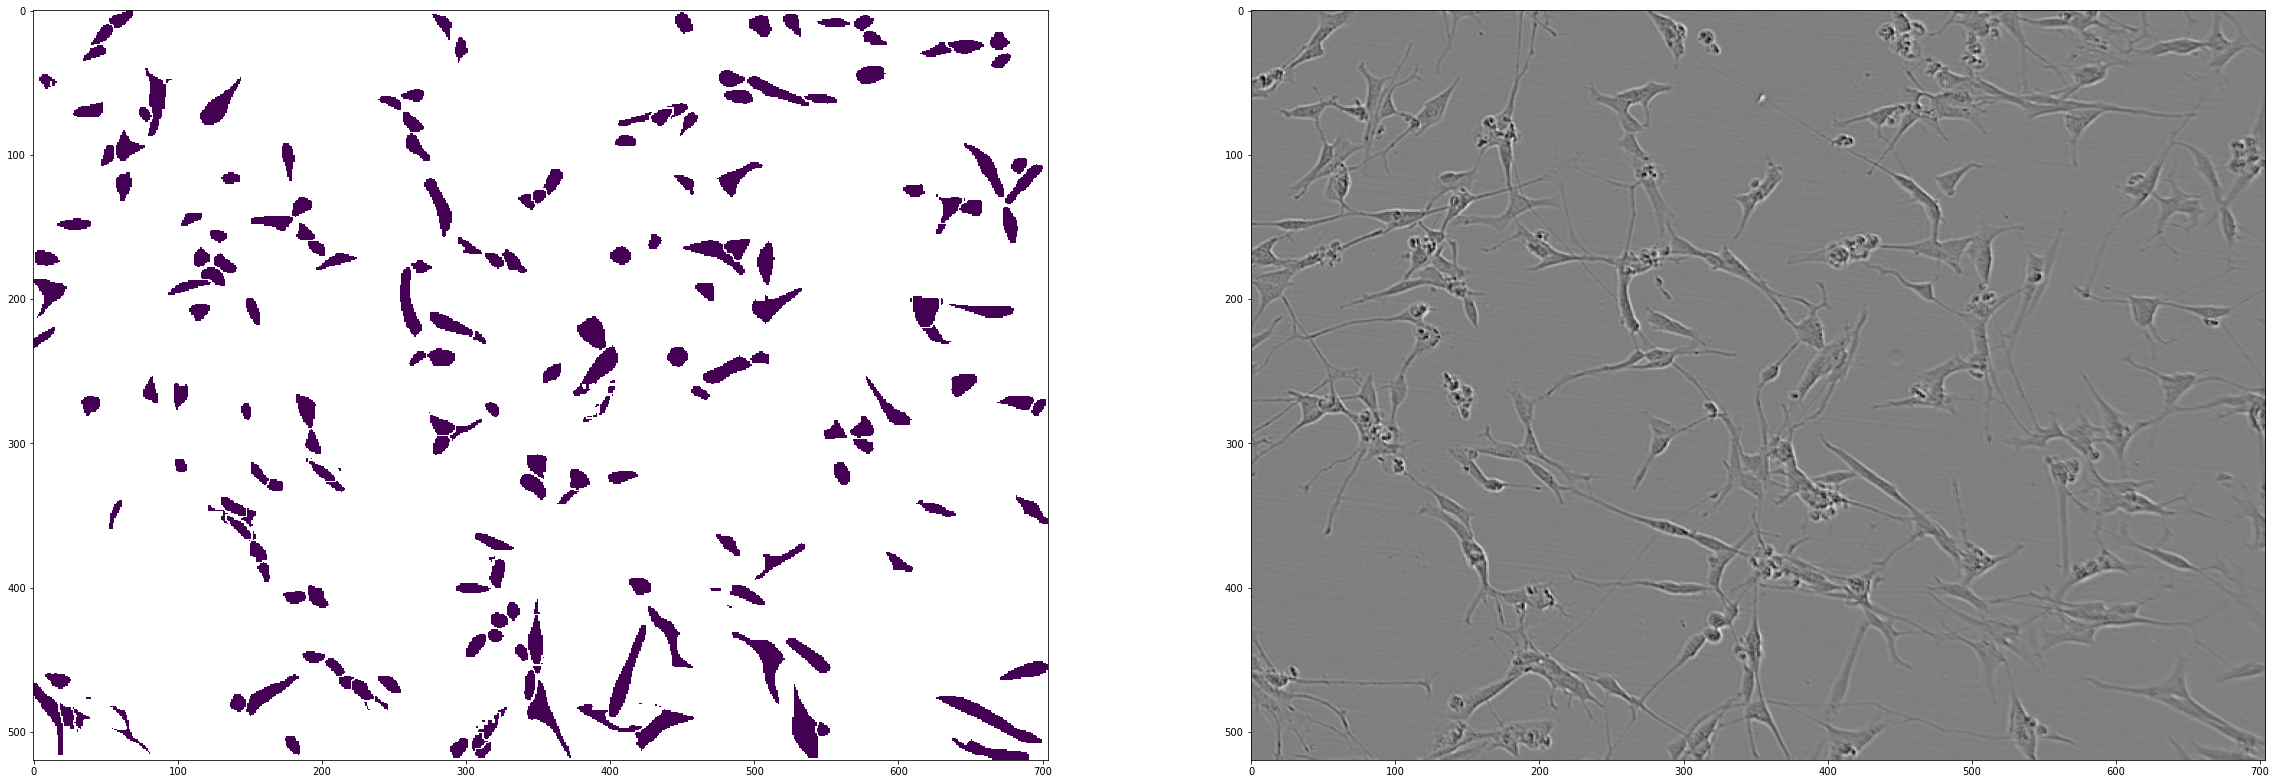

In [7]:
encoded_masks = get_masks(test_names[0], predictor)

_, axs = plt.subplots(1,2, figsize=(40,15))
axs[1].imshow(cv2.imread(str(test_names[0])))
mask_decode = np.zeros((520,704)).astype(np.int64)
for enc in encoded_masks:
    dec = rle_decode(enc)
    mask_decode += np.ma.masked_where(dec==0, dec) 
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

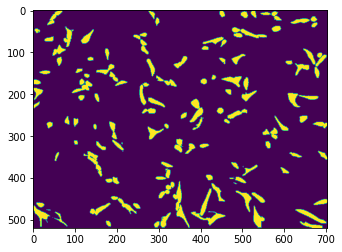

In [8]:
plt.imshow(mask_decode)

In [ ]:
# def rle_encode(img):
#     pixels = img.flatten()
#     pixels = np.concatenate([[0], pixels, [0]])
#     runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
#     runs[1::2] -= runs[::2]
#     return ' '.join(str(x) for x in runs)

# mask = rle_encode(encoded_masks[0])
# # print(np.unique(mask))
# # plt.imshow(mask)
# type(mask)

### Looks good, so lets generate masks for all the files and create a submission

In [ ]:
for fn in test_names:
    encoded_masks = get_masks(fn, predictor)
    for enc in encoded_masks:
        ids.append(fn.stem)
        masks.append(enc)

In [ ]:
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

# Local CV:

In [9]:
def compute_iou(labels, y_pred):
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union
    
    return iou[1:, 1:]  # exclude background

def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def iou_map(truths, preds, verbose=0):
    ious = [compute_iou(truth, pred) for truth, pred in zip(truths, preds)]
    
#     print(ious[0].shape)

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

In [43]:
import json
with open("/kaggle/input/sartorius-coco-dataset-notebook/val_dataset.json") as f:
    val_data = json.load(f)

    
val_file_name = []
for i in range(len(val_data['images'])):
    val_file_name.append("/kaggle/" + val_data['images'][i]['file_name'][3:-1]+'g')
    
# val_file_name[0].split('/')[-1]

'f00798e9b1eb.png'

In [41]:
# ! ls -GFlash --color /kaggle/input/sartorious-nb-1-data-preprocessing-visualization/masks/img

In [35]:
def get_val_mask(val_file_name):
    val_mask = []
    
    for i in val_file_name:
        encoded_masks = get_masks(i, predictor)
        mask_decode = np.zeros((520,704)).astype(np.int64)
        for enc in encoded_masks:
            dec = rle_decode(enc)
            mask_decode += np.ma.masked_where(dec==0, dec)
            
        val_mask.append(mask_decode)
    return val_mask

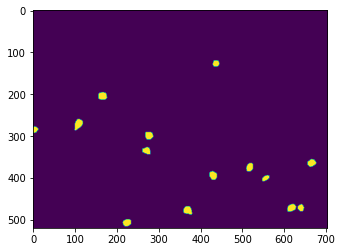

In [59]:
pred_masks = get_val_mask(val_file_name)
plt.imshow(pred_masks[30])

In [52]:
train_csv = "../input/sartorius-cell-instance-segmentation/train.csv"

df = pd.read_csv(train_csv)

In [63]:
def rle_decode1(mask_rle, shape, color=1):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)
    

def build_masks(image_id,input_shape=(520,704), colors=False):
    height, width = input_shape
    labels = df[df["id"] == image_id]["annotation"].tolist()
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode1(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode1(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

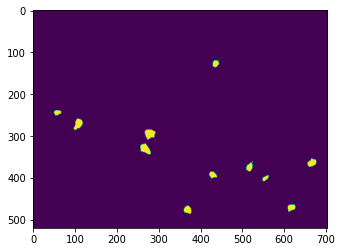

In [65]:
gt_mask = []
for fn in val_file_name:
    mask_id = fn.split('/')[-1].split('.')[0]
    mask_from_df = build_masks(mask_id)
    gt_mask.append(mask_from_df)
    
plt.imshow(gt_mask[30])

In [66]:
# plt.imshow(gt_mask[22])

In [68]:
all_map = []
for i in range(len(pred_masks)):
    all_map.append(iou_map(gt_mask[i],pred_masks[i],verbose=1))
    
print(np.mean(all_map))

Thresh	TP	FP	FN	Prec.
0.500	139	381	364	0.157
0.550	87	433	416	0.093
0.600	42	478	461	0.043
0.650	15	505	488	0.015
0.700	3	517	500	0.003
0.750	0	520	503	0.000
0.800	0	520	503	0.000
0.850	0	520	503	0.000
0.900	0	520	503	0.000
0.950	0	520	503	0.000
AP	-	-	-	0.031
Thresh	TP	FP	FN	Prec.
0.500	130	367	390	0.147
0.550	79	418	441	0.084
0.600	50	447	470	0.052
0.650	40	457	480	0.041
0.700	39	458	481	0.040
0.750	23	474	497	0.023
0.800	13	484	507	0.013
0.850	7	490	513	0.007
0.900	0	497	520	0.000
0.950	0	497	520	0.000
AP	-	-	-	0.041
Thresh	TP	FP	FN	Prec.
0.500	103	49	189	0.302
0.550	101	51	191	0.294
0.600	95	57	197	0.272
0.650	90	62	202	0.254
0.700	81	71	211	0.223
0.750	69	83	223	0.184
0.800	56	96	236	0.144
0.850	38	114	254	0.094
0.900	19	133	273	0.045
0.950	7	145	285	0.016
AP	-	-	-	0.183
Thresh	TP	FP	FN	Prec.
0.500	135	72	144	0.385
0.550	125	82	154	0.346
0.600	119	88	160	0.324
0.650	99	108	180	0.256
0.700	84	123	195	0.209
0.750	65	142	214	0.154
0.800	52	155	227	0.120
0.850	41	166	238	0.092
0.900	